11 December 2023

**Author:** Luna Herschenfeld-Catalan

Link to repository: https://github.com/lunacatalan/biodiversity-loss-phoenix

# Background

Exploration into biodiversity loss in Phoenix between 2017 and 2020. 

## Data

### Dateset 1: **Biodiversity Intactness Index (BII) data** 

This dataset can be found as part of the MPC STAC catalog. We first have to access the `io-biodiversity` collection and look for the 2017 and 2020 rasters covering Phoenix subdivision. 

The bounding box coordiantes are: [-112.826843, 32.974108, -111.184387, 33.863574]

### Dataset 2: **Phoenix subdivision Shapefile**  

The Phoenix subdivision polygon is in the Census County Subdivision shapefiles for Arizona: https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2022&layergroup=County+Subdivisions

# Prepare the Data

## Load Libraries and MPC

In [24]:
import numpy as np
import geopandas as gpd
import rioxarray as rioxr
import matplotlib.pyplot as plt
# libraries for point geometry 
import pandas as pd

from shapely.geometry import Polygon 
# for creating legends
import matplotlib.patches as mpatches 

# library to access catalog
from pystac_client import Client
# used to sign items from the MPC STAC catalog 
import planetary_computer

from IPython.display import Image

import contextily as ctx # for adding basemaps

## Access collection with Biodiversity data

We want to access the `io-biodiversity` collection. First we need to load the catalog.

In [2]:
# access the catalog
catalog = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier = planetary_computer.sign_inplace)


### Select the data of interest

Use the coordinats: [-112.826843, 32.974108, -111.184387, 33.863574]

Select the years: 2017 and 2020

In [3]:
# create bbox using coordinates
bbox = [-112.826843, 32.974108, -111.184387, 33.863574]

#determine timerange
timerange = "2017/2020"

search = catalog.search(
    collections=["io-biodiversity"], # identify collection 
    #intersects=bbox_qazvin,
    bbox = bbox, # set bbox
    datetime = timerange # set timerange 
)

items = search.item_collection()


id: bii_2020_34.74464974521749_-115.38597824385106_cog
"bbox: [-115.3859782, 27.565314, -108.2066425, 34.7446497]"
datetime: None
proj:epsg: 4326
"proj:shape: [7992, 7992]"
end_datetime: 2020-12-31T23:59:59Z
"proj:transform: [0.0008983152841195215, 0.0, -115.38597824385106, 0.0, -0.0008983152841195215, 34.74464974521749, 0.0, 0.0, 1.0]"
start_datetime: 2020-01-01T00:00:00Z
https://stac-extensions.github.io/projection/v1.0.0/schema.json
https://stac-extensions.github.io/raster/v1.1.0/schema.json
https://stac-extensions.github.io/version/v1.1.0/schema.json


### Select the items that match the 2020 and 2017 data

In [4]:
# the 1st item in the collection is the 2020 raster
bio_20 = items[0]

# the 4thst item in the collection is the 2020 raster
bio_17 = items[3]

# Prepare Phoenix County Data

Read in the Arizona county shapefile:

In [5]:
# read the shapefile in for all Arizona coutnies
counties = gpd.read_file('data/tl_2022_04_cousub/tl_2022_04_cousub.shp')
counties.head(2)

,STATEFP,COUNTYFP,COUSUBFP,COUSUBNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CNECTAFP,NECTAFP,NCTADVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,04,005,91198,01934931,0400591198,Flagstaff,Flagstaff CCD,22,Z5,G4040,NaN,NaN,NaN,S,12231052883,44653332,+35.1066114,-111.3662497,"POLYGON ((-112.13370 35.85596, -112.13368 35.8..."
1,04,005,91838,01934953,0400591838,Kaibab Plateau,Kaibab Plateau CCD,22,Z5,G4040,NaN,NaN,NaN,S,7228864534,29327221,+36.5991097,-112.1368033,"POLYGON ((-112.66039 36.53941, -112.66033 36.5..."


Select only Phoenix:

In [6]:
# select phoenix
phoenix = counties[counties.NAME == "Phoenix"]

# check to see if correct polygon was selected
phoenix

,STATEFP,COUNTYFP,COUSUBFP,COUSUBNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CNECTAFP,NECTAFP,NCTADVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
10,04,013,92601,01934968,0401392601,Phoenix,Phoenix CCD,22,Z5,G4040,NaN,NaN,NaN,S,2806478817,9471127,+33.5211331,-112.0284405,"POLYGON ((-112.47014 33.55996, -112.47011 33.5..."


In [ ]:
# plot to see the shape 
phoenix.plot()

## Create a map of Phoenix

Show the Phoenix subdivision within an appropriate geographical context. You may use any vector datasets to create your map. 

Text(0.5, 1.0, 'SB County')

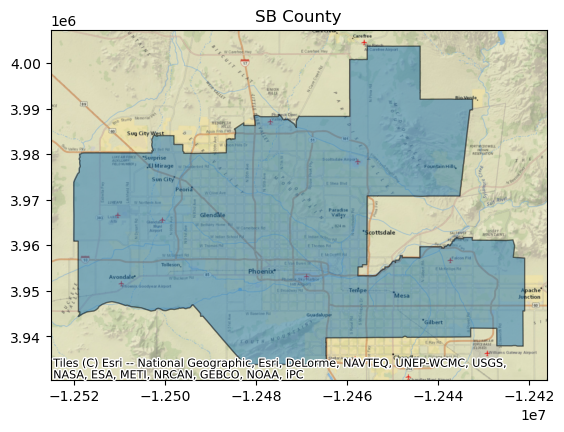

In [7]:
fig, ax = plt.subplots()

# plot phoenix
(phoenix.to_crs(epsg=3857) # change crs to the same one as basemap
.plot(ax = ax, 
     figsize = (5,5),
     alpha = 0.5,
     edgecolor = 'k') # make edgecolor black
)

# add basemap
ctx.add_basemap(ax, 
               source = ctx.providers.Esri.NatGeoWorldMap)

# add title
ax.set_title('SB County')

## Calculate the percentage of area 

Phoenix subdivision with a BII of at least 0.75 in 2017. Obtain the same calculation for 2020.

In [8]:
# look at the rendered preview
Image(url = bio_20.assets['rendered_preview'].href, 
      width = 500)


#### Prepare rasters 

1. Open the rasters
2. Make sure they are in the same CRS for plotting 

In [9]:
# open the rasters fom 2020 and 2017
phoenix_20 = rioxr.open_rasterio(bio_20.assets['data'].href)
phoenix_17 = rioxr.open_rasterio(bio_17.assets['data'].href)

# transform phoenix geometry to phoenix 2020 raster crs
phx_crs = phoenix.to_crs(phoenix_20.rio.crs)

# check to see if these are equal now
phx_crs.crs == phoenix_20.rio.crs

### Clip the rasters to the `Phoenix` geometry

In [12]:
# get the shape of phoenix
phx_20 = phoenix_20.rio.clip(phx_crs['geometry'])
phx_17 = phoenix_17.rio.clip(phx_crs['geometry'])

Check the plot to see if the raster was clipped successfully:

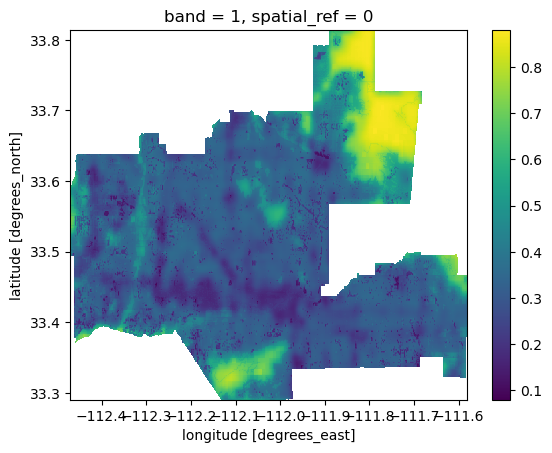

In [13]:
# check to see if the data has clipped correctly  
phx_20.plot()

### Prepare data for calcualting the change in biodiversity

Select the vales that are greater than 0.75 from both the 2017 and 2020 `DataArray`'s:

In [15]:
# select the values that are greater than 0.75 from the 2020 and 2017 data 
bii_20_phx = phx_20>=0.75
bii_17_phx = phx_17>=0.75

These values have nan, which are going to be hard to plot later on.

In [ ]:
# explore the values in the raster
bii_20_phx

The array has binary values (T/F). These values wont be able to be converted to percent so we have to change them back into integer values:

In [16]:
# change to type integer to be able to get the percent and change later
bii_phoenix_20 = bii_20_phx.astype(int)
bii_phoenix_17 = bii_17_phx.astype(int)

In [2]:
# check the array values to see if they have changed from NA to 0
bii_phoenix_20

### Calculate the percentage of area with BII over 0.75 in 2020 and 2017 and the change

Find the percent of area covered in 2020 and 2017:

In [17]:
# calculate the percent of pixels by taking the sum (since the values are 1) and dividing it by total pixels 
percent_20 = (bii_phoenix_20.sum().item()) / (bii_phoenix_20.count().item())* 100
percent_17 = (bii_phoenix_17.sum().item()) / (bii_phoenix_17.count().item())* 100

Do some map algebra and find the change by subtracting the 2017 percentage covered from the 2020 percentage covered:

In [18]:
# calculate the change in area covered
change = bii_phoenix_20 - bii_phoenix_17

# calculate the percent of pixels by taking the sum (since the values are 1) and dividing it by total pixels 
change_percent = (change.sum().item() / change.count().item())*100
print(f"The percent change between 2017 and 2020 was {round(change_percent, 3)}")

See what the change plot looks like:

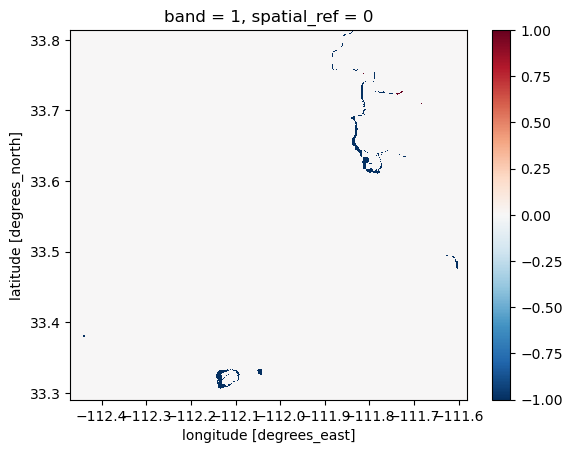

In [20]:
# plot to see what change looks like 
change.plot()

# Plot the difference

First, change 0 to nan values. Since the change was negative, we can convert the values that are not equal to -1 to 0.

In [21]:
# make everything not a -1 an na value
bii_change = change.where(change == -1)

xarray.core.dataarray.DataArray

Plot it!

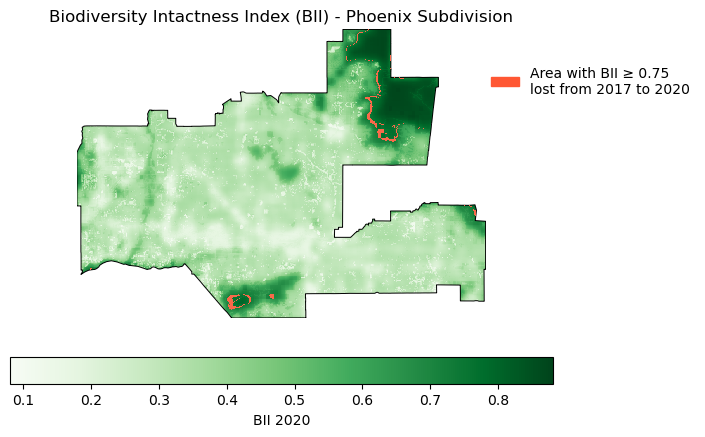

In [47]:
#---- Plot set up ----#
fig, ax = plt.subplots(figsize = (7,5))
ax.axis('off') # remove axis

#---- Add phoenix with BII and Outline----#

# plot the bii values in 2020
phx_bii = phx_20.plot(ax=ax,
                      cmap = "Greens", # color in shades of green
                      add_colorbar = False) # remove colorbar here

# outline of the area
phoenix.plot(ax=ax,
             facecolor="none",
             edgecolor="black",
             linewidth=0.7)

#---- Add Change to plot  ----#

# plot lost area
bii_change.plot(ax=ax, 
          cmap = 'Reds', # update color map to be visible ontop of BII
          add_colorbar=False) # remove color bar 

# make legend patch for the BII change 
change_patch = mpatches.Patch(color='#FF5733', # patch for lost area
                           label='Area with BII ≥ 0.75 \nlost from 2017 to 2020')


#---- Customize the title and legend ----#

# titles 
ax.set_title("Biodiversity Intactness Index (BII) - Phoenix Subdivision")

# legend for lost area
ax.legend(handles=[change_patch], # add change patch to legend
          frameon=False,
          loc = (1, 0.75))

# add color bar to bottom of plot
fig.colorbar(phx_bii, 
             orientation="horizontal", # make bar horizontal
             pad=0.1, # distance from bar to the plot 
             label = "BII 2020")

It would be interesting to compare the biodiversity loss from different cities, or to see if there has been an acceleration in the percentage change. These results are only from 2017 to 2020, but I wonder if there is the same percentage of change from 2020 to 2023, or the three years before this analysis (2014-2017). This could reveal if there has been a change in the rate of biodiversity loss.